# Feature detection and matching

## Motivation

Features are used for:
- Automatic panoramas
- Indexing and content-based retrieval (ex: Google images,...)
- Object recognition
- 3D reconstruction
- Motion tracking
- Robot navigation
- ...

## Which features are good to choose

*Choose features that are invariant to transformations*

**Invariant local features**
- Corners
- Blobs
- ...

**Advantages of local features**:
- Locality: robust to occlusion and clutter
- Quantity: hundreds or thousands in a single image
- Distinctiveness: can differentiate a large database of objects
- Efficiency: real-time performance achievable

*What about edges*
- Edges can be invariant to brightness changes but typically not invariant to other transformations

*Note on transformations*:
- Geometric invariance: translation, rotation, scale
- Photometric invariance: brightness, exposure

**Idea to measure the uniqueness of a feature**
- Consider a small window of pixels
- "Observe" how does the window change when you shift it
    - "flat" region: no change in all directions
    - "edge" region: no change along the edge direction
    - "corner": significant change in all directions

# Harris corner detection

## High-level pseudocode

0. Apply a Gaussin filter to smooth out any noise
1. Convert the original image to a grayscale one
2. Calculate x and y gradient values for each pixel in the image
3. For each pixel p in the grayscale image, consider a 3x3 window around it and compute the corner strength function. Call this its Harris value
4. Find all pixels that exceed a certain threshold and are the local maxima within a certain window
5. For each pixel that meets the criteria in 5, compute a feature descriptor

https://medium.com/data-breach/introduction-to-harris-corner-detector-32a88850b3f6

## Derivative of an image

*Note: Differentiating an image in X and Y:*
$$
I_x = \frac{\partial I}{\partial x} \approx F(x+1,y) - F(x,y)
$$
$$
I_y = \frac{\partial I}{\partial y} \approx F(x,y+1) - F(x,y)
$$

In [3]:
def derivative(image):
    I_x1 = np.hstack([image[:,1:], image[:,-1].reshape(image.shape[0], 1)])
    I_y1 = np.vstack([image[1:,:], image[-1,:].reshape(1, image.shape[1])])
    
    Ix = I_x1 - image
    Iy = I_y1 - image

    return Ix, Iy


In [4]:
Ix, Iy = derivative(F_gray)

In [ ]:
imshow(Ix, Iy)

## Sum of squared difference "error"

Consider shifting the window $W$ by $(u,v)$

Sum of squared differences **(SSD "error")**:
$$
E(u,v) = \sum_{(x,y)\in W} (I(x+u, y+v) - I(x, y))^2
$$

## H matrix

$$
H = \begin{bmatrix} A & B \\ B & C \end{bmatrix}
$$

In [ ]:
# W = [row_start, row_end, column_start, column_end]
def H_matrix(Ix, Iy, W):
    r_start, r_end, c_start, c_end = W

    A = np.sum(Ix[r_start:r_end, c_start:c_end] ** 2)

    B = np.sum(
        Ix[r_start:r_end, c_start:c_end]
        * Iy[r_start:r_end, c_start:c_end]
    )

    C = np.sum(Iy[r_start:r_end, c_start:c_end] ** 2)

    return np.array([[A, B], 
                     [B, C]])

with weight:
$$
H = w \begin{bmatrix} A & B \\ B & C \end{bmatrix}
$$

In [5]:
# k is the neighbor size
def generate_gaussian_kernel(sigma, k):
    l = 2 * k + 1
    kernel = np.zeros((l,l))
    double_sigma_2 = 2 * np.power(sigma, 2)
    constant = 1 / (2 * np.pi * double_sigma_2)
    for i in range(l):
        for j in range(l):
            kernel[i, j] = constant * np.power(np.e, -(i**2 + j**2) / double_sigma_2)
    
    return kernel

In [6]:
# H must be the kernel of size (2k + 1)^2
def convolution(F, H):
    k = H.shape[0] // 2
    F_height, F_width = F.shape
    min_row = k
    min_col = k
    max_row = F_height - k
    max_col = F_width - k
    
    G = np.zeros(F.shape)
    depth = 1 if len(G.shape) == 2 else 3
    for d in range(depth):
        for i in range(min_row, max_row):
            for j in range(min_col, max_col):
                tmp = F[i-k:i+k+1, j-k:j+k+1]
                tmp = np.flip(tmp, (0, 1))
                G[i, j] = np.sum(tmp * H)
    
    return G

In [14]:
# W = [row_start, row_end, column_start, column_end]
def H_matrix_with_filter(Ix, Iy, kernel, W):
    r_start, r_end, c_start, c_end = W
    
    Ix_W = convolution(Ix[r_start:r_end, c_start:c_end], kernel)
    Iy_W = convolution(Iy[r_start:r_end, c_start:c_end], kernel)

    A = np.sum(Ix_W ** 2)
    B = np.sum(Ix_W * Iy_W)
    C = np.sum(Iy_W ** 2)

    return np.array([[A, B], 
                     [B, C]])

## Eigenvalues

$$
\lambda_{\pm} = \frac{1}{2}(A + C \pm \sqrt{4B^2 - (A - C)^2})
$$

In [8]:
def eigenvalues(h_matrix):
    a = h_matrix[0,0] + h_matrix[1,1]
    b = np.sqrt(4 * h_matrix[0,1] * h_matrix[1,0] - (h_matrix[0,0] - h_matrix[1,1]) ** 2)
    lambda1 = 0.5 * (a + b)
    lambda2 = 0.5 * (a - b)
    return lambda1, lambda2

## Harris operator

In [9]:
def harris_operator(lambda1, lambda2):
    return lambda1 * lambda2 / (lambda1 + lambda2)

## Test harris corner

## Harris corner

In [15]:
def harris_corner(src, neighborhood_size):
    window_size = neighborhood_size * 2 + 1
    dst = np.zeros(src.shape)
    Ix, Iy = derivative(src)
    for i in range(neighborhood_size, src.shape[0] - neighborhood_size):
        for j in range(neighborhood_size, src.shape[1] - neighborhood_size):
            r_start = i - neighborhood_size
            c_start = j - neighborhood_size
            r_end = r_start + window_size
            c_end = c_start + window_size

            W = [r_start, r_end, c_start, c_end]

            gaussian_kernel = generate_gaussian_kernel(3, neighborhood_size)
            H = H_matrix_with_filter(Ix, Iy, gaussian_kernel, W)

            lambda1, lambda2 = eigenvalues(H)
            f = harris_operator(lambda1, lambda2)

            dst[i, j] = f
    return dst            


In [40]:
dst = harris_corner(F_gray, 1)

In [26]:
def thresholding(src, harris_corner_result, threshold, window_size):
    for r_start in range(0, src.shape[0] - window_size, window_size):
        for c_start in range(0, src.shape[1] - window_size, window_size):
            r_end = r_start + window_size
            c_end = c_start + window_size
            f_max = harris_corner_result[r_start:r_end, c_start:c_end].max()
            if f_max < threshold:
                continue
            for r in range(r_start, r_end):
                for c in range(c_start, c_end):
                    if harris_corner_result[r,c] == f_max:
                        break
            rs = np.clip(r - 1, 0, src.shape[0])
            cs = np.clip(c - 1, 0, src.shape[1])
            re = np.clip(r + 1, 0, src.shape[0])
            ce = np.clip(c + 1, 0, src.shape[1])
            src[rs:re,cs:ce] = [255,0,0]

In [42]:
result = np.copy(F_rgb)
thresholding(result, dst, 200, 3)
imshow(result)

ValueError: zero-size array to reduction operation maximum which has no identity

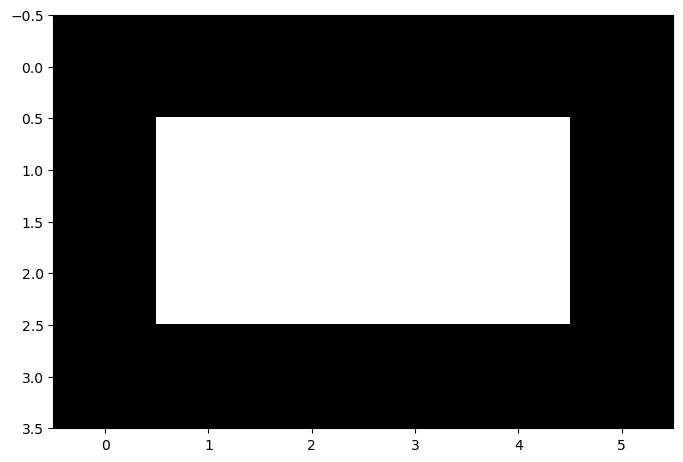

In [41]:
imshow(dst)

## Miscs.

**Load image**

In [1]:
import cv2
from cv2 import COLOR_BGR2RGB
from cv2 import COLOR_BGR2GRAY

import numpy as np

from matplotlib import pyplot as plt

def imshow(*imgs, dpi=100):
    fig=plt.figure(figsize=(8, 8), dpi=dpi)
    columns = len(imgs)
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if len(imgs[i-1].shape) == 2:
            plt.imshow(imgs[i-1], cmap='gray')
        else:
            plt.imshow(imgs[i-1])
    plt.show()

In [2]:
image_file = '../images/council_house.jpg'

tmp  = cv2.imread(image_file)
h, w = tmp.shape[0], tmp.shape[1]
new_h = 500
new_w = new_h * h // w

F_bgr  = cv2.resize(tmp, (new_h,new_w))
F_rgb  = cv2.cvtColor(F_bgr, COLOR_BGR2RGB)
F_gray = cv2.cvtColor(F_bgr, COLOR_BGR2GRAY)
F_gray_float32 = np.float32(F_gray)

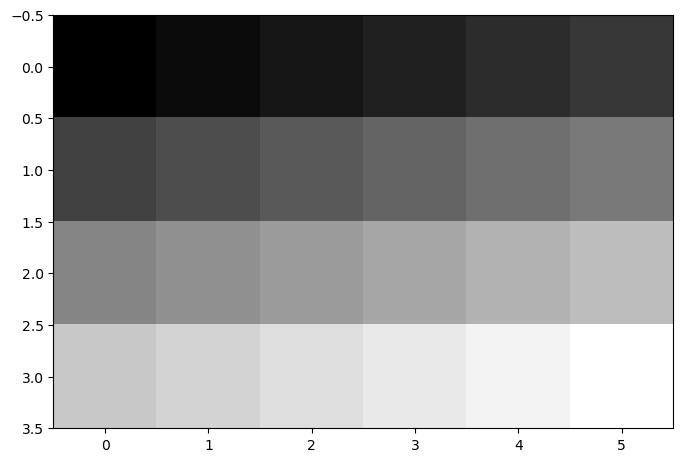

In [39]:
F_gray = np.arange(24, dtype=np.float32).reshape(4, 6)
imshow(F_gray)

### Use cv2

In [ ]:
# https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345
# https://docs.opencv.org/master/dc/d0d/tutorial_py_features_harris.html
dst_1 = cv2.cornerHarris(F_gray_float32,2,3,0.04)

result = np.copy(F_rgb)
result[dst_1>0.01*dst_1.max()]=[255,0,0]
imshow(result)

https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect6.pdf